# ICP 点云精配准
本教程演示了ICP（迭代最接近点）配准算法。多年来，它一直是研究和工业领域中几何配准的主流。
输入是两个点云和一个初始变换，该变换将源点云与目标点云大致对齐。输出是一个细化的变换，将两个点云紧密地对齐。
在配准过程中，一个辅助函数draw_registration_result将对齐情况可视化。
在本教程中，我们展示了两个ICP变体，点对点ICP和点对平面ICP

In [1]:
import open3d as o3d
import open3d_example as o3de
import numpy as np
import copy,time,re,os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## 初始化

In [ ]:
# 辅助的可视化函数
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 1])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp],
                                      zoom=0.4459,
                                      front=[0.9288, -0.2951, -0.2242],
                                      lookat=[1.6784, 2.0612, 1.4451],
                                      up=[-0.3402, -0.9189, -0.1996])

In [ ]:
# 制作算法输入
# 从两个文件中读取一个源点云和一个目标点云。给出了一个粗略的变换。
# 最初的对齐方式通常是通过全局配准算法得到的。例子见全局配准。

source = o3d.io.read_point_cloud("PointCloudData\\DemoICPPointClouds\\cloud_bin_0.pcd")
target = o3d.io.read_point_cloud("PointCloudData\\DemoICPPointClouds\\cloud_bin_1.pcd")
threshold = 0.02
trans_init = np.asarray([[0.862, 0.011, -0.507, 0.5],
                         [-0.139, 0.967, -0.215, 0.7],
                         [0.487, 0.255, 0.835, -1.4], 
                         [0.0, 0.0, 0.0, 1.0]])
draw_registration_result(source, target, trans_init)


In [ ]:
# 函数 evaluate_registration 计算两个主要指标。
# fitness，衡量重叠的区域(# inlier correspondences / # of points in target)。越高越好。
# inlier_rmse, 衡量所有inlier对应点的RMSE。越低越好。
print("Initial alignment")
evaluation = o3d.pipelines.registration.evaluate_registration(
  source, target, threshold, trans_init)
print(evaluation)

## 点对点 ICP
一般来说，ICP算法经过两步迭代。

1. 从目标点云P和用当前变换矩阵T变换的源点云Q中找到对应集K={(p,q)}。
2. 通过最小化定义在对应集K上的目标函数E(T)来更新变换T。

不同的ICP变体使用不同的目标函数E（T）

TransformationEstimationPointToPoint类提供了计算点对点ICP目标的残差和雅各布矩阵的函数。函数registration_icp将其作为参数，并运行点对点ICP来获得结果

In [ ]:
print("Apply point-to-point ICP")
reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint())
print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)
draw_registration_result(source, target, reg_p2p.transformation)

In [ ]:
# 默认情况下，registration_icp运行到收敛或达到最大迭代次数（默认为30次）。
# 可以改变它以允许更多的计算时间并进一步改善结果。
reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint(),
    o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=2000))
print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)
draw_registration_result(source, target, reg_p2p.transformation)

## 点对面 ICP
点对平面的ICP算法[ChenAndMedioni1992]使用一个不同的目标函数

其中np是p点的法线。[Rusinkiewicz2001]表明，点到平面的ICP算法比点到点的ICP算法具有更快的收敛速度。

registration_icp被调用时有一个不同的参数TransformationEstimationPointToPlane。在内部，这个类实现了计算点对平面ICP目标的残差和雅各布矩阵的函数。

**点对平面的ICP算法使用点法线。在本教程中，我们从文件中加载法线。如果没有给出法线，可以用顶点法线估计来计算**

In [ ]:
print("Apply point-to-plane ICP")
reg_p2l = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPlane())
print(reg_p2l)
print("Transformation is:")
print(reg_p2l.transformation)
draw_registration_result(source, target, reg_p2l.transformation)

# 鲁棒核ICP
本教程演示了鲁棒核在剔除异常值方面的使用。在这个特定的教程中，我们将使用ICP（迭代最接近点）配准算法作为我们要处理异常值的目标问题。即便如此，该理论也适用于任何特定的优化问题，而不仅仅是ICP。目前，鲁棒的核子只在PointToPlane ICP中实现。

### 初始化
初始对齐通常由全局配准算法获得。例子见全局配准。

In [ ]:
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp],
                                      zoom=0.4459,
                                      front=[0.9288, -0.2951, -0.2242],
                                      lookat=[1.6784, 2.0612, 1.4451],
                                      up=[-0.3402, -0.9189, -0.1996])
source = o3d.io.read_point_cloud("PointCloudData\\DemoICPPointClouds\\cloud_bin_0.pcd")
target = o3d.io.read_point_cloud("PointCloudData\\DemoICPPointClouds\\cloud_bin_1.pcd")
# threshold = 0.2
trans_init = np.asarray([[0.862, 0.011, -0.507, 0.5],
                         [-0.139, 0.967, -0.215, 0.7],
                         [0.487, 0.255, 0.835, -1.4], [0.0, 0.0, 0.0, 1.0]])
draw_registration_result(source, target, trans_init)


In [ ]:
# 为了更好地展示在配准中使用鲁棒核的优势，我们在源点云中加入一些人工生成的高斯噪声。
def apply_noise(pcd, mu, sigma):
    noisy_pcd = copy.deepcopy(pcd)
    points = np.asarray(noisy_pcd.points)
    points += np.random.normal(mu, sigma, size=points.shape)
    noisy_pcd.points = o3d.utility.Vector3dVector(points)
    return noisy_pcd


mu, sigma = 0, 0.1  # mean and standard deviation
source_noisy = apply_noise(source, mu, sigma)

print("Source PointCloud + noise:")
o3d.visualization.draw_geometries([source_noisy],
                                  zoom=0.4459,
                                  front=[0.353, -0.469, -0.809],
                                  lookat=[2.343, 2.217, 1.809],
                                  up=[-0.097, -0.879, 0.467])


### 普通icp对比

In [ ]:
# 普通icp
threshold = 0.02
print("Vanilla point-to-plane ICP, threshold={}:".format(threshold))
p2l = o3d.pipelines.registration.TransformationEstimationPointToPlane()
reg_p2l = o3d.pipelines.registration.registration_icp(source_noisy, target,
                                                      threshold, trans_init,
                                                      p2l)

print(reg_p2l)
print("Transformation is:")
print(reg_p2l.transformation)
draw_registration_result(source, target, reg_p2l.transformation)


In [ ]:
# 调整普通ICP
# 鉴于我们现在处理的是高斯噪声，我们可以尝试增加阈值来搜索最近的邻居，以改善配准结果。
# 我们可以看到，在这些条件下，如果没有一个健壮的内核，传统的ICP没有机会处理离群值
threshold = 1.0
print("Vanilla point-to-plane ICP, threshold={}:".format(threshold))
p2l = o3d.pipelines.registration.TransformationEstimationPointToPlane()
reg_p2l = o3d.pipelines.registration.registration_icp(source_noisy, target,
                                                      threshold, trans_init,
                                                      p2l)

print(reg_p2l)
print("Transformation is:")
print(reg_p2l.transformation)
draw_registration_result(source, target, reg_p2l.transformation)


### 鲁棒核ICP

In [ ]:
# 鲁棒核ICP
# 使用相同的阈值=1.0和一个稳健的内核，我们可以正确地配准两个点云。
threshold = 1
print("Robust point-to-plane ICP, threshold={}:".format(threshold))
loss = o3d.pipelines.registration.TukeyLoss(k=sigma)
print("Using robust loss:", loss)
p2l = o3d.pipelines.registration.TransformationEstimationPointToPlane(loss)
reg_p2l = o3d.pipelines.registration.registration_icp(source_noisy, target,
                                                      threshold, trans_init,
                                                      p2l)
print(reg_p2l)
print("Transformation is:")
print(reg_p2l.transformation)
draw_registration_result(source, target, reg_p2l.transformation)

# 对于参数k，我们将其设置为与噪声模型的标准偏差k=σ相匹配。
# Robust Kernels中使用的参数k通常被选为与输入数据的噪声模型的标准差相匹配。
# 在这个意义上，k是区分离群者/离群者的工具。
# 尽管这在现实世界的数据中并不总是那么容易定义，但对于合成数据来说，为了说明鲁棒核的好处，这很容易固定下来。

# 彩色点云配准
本教程演示了一个ICP变体，它同时使用几何和颜色进行配准。它实现了[Park2017]的算法。颜色信息锁定了沿切线平面的对齐。因此，这个算法比之前的点云配准算法更准确、更稳健，而运行速度与ICP配准的速度相当。本教程使用ICP配准的符号。

### 初始化

In [ ]:
def draw_registration_result_original_color(source, target, transformation):
    source_temp = copy.deepcopy(source)
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target],
                                      zoom=0.5,
                                      front=[-0.2458, -0.8088, 0.5342],
                                      lookat=[1.7745, 2.2305, 0.9787],
                                      up=[0.3109, -0.5878, -0.7468])
print("1. Load two point clouds and show initial pose")
# demo_colored_icp_pcds = o3d.data.DemoColoredICPPointClouds()
# source = o3d.io.read_point_cloud(demo_colored_icp_pcds.paths[0])
# target = o3d.io.read_point_cloud(demo_colored_icp_pcds.paths[1])

source = o3d.io.read_point_cloud("PointCloudData\\DemoICPPointClouds\\cloud_bin_0.pcd")
target = o3d.io.read_point_cloud("PointCloudData\\DemoICPPointClouds\\cloud_bin_1.pcd")
# draw initial alignment
current_transformation = np.identity(4)
draw_registration_result_original_color(source, target, current_transformation)


### 点对面的ICP(作对比，与上同)
首先运行点对平面ICP作为一个基准方法。下面的可视化图显示了错位的绿色三角形纹理。这是因为几何约束并不能阻止两个平面的滑移。

In [ ]:
# point to plane ICP
current_transformation = np.identity(4)# 这里更改了初始矩阵，导致效果差
print("2. Point-to-plane ICP registration is applied on original point")
print("   clouds to refine the alignment. Distance threshold 0.02.")
result_icp = o3d.pipelines.registration.registration_icp(
    source, target, 0.02, current_transformation,
    o3d.pipelines.registration.TransformationEstimationPointToPlane())
print(result_icp)
draw_registration_result_original_color(source, target,
                                        result_icp.transformation)


### 彩色点云配准
（也不是很准）

In [ ]:
# colored pointcloud registration
# This is implementation of following paper
# J. Park, Q.-Y. Zhou, V. Koltun,
# Colored Point Cloud Registration Revisited, ICCV 2017
voxel_radius = [0.04, 0.02, 0.01]
max_iter = [50, 30, 14]
current_transformation = np.identity(4)
print("3. Colored point cloud registration")
for scale in range(3):
    iter = max_iter[scale]
    radius = voxel_radius[scale]
    print([iter, radius, scale])

    print("3-1. Downsample with a voxel size %.2f" % radius)
    source_down = source.voxel_down_sample(radius)
    target_down = target.voxel_down_sample(radius)

    print("3-2. Estimate normal.")
    source_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius * 2, max_nn=30))
    target_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius * 2, max_nn=30))

    print("3-3. Applying colored point cloud registration")
    result_icp = o3d.pipelines.registration.registration_colored_icp(
        source_down, target_down, radius, current_transformation,
        o3d.pipelines.registration.TransformationEstimationForColoredICP(),
        o3d.pipelines.registration.ICPConvergenceCriteria(relative_fitness=1e-6,
                                                          relative_rmse=1e-6,
                                                          max_iteration=iter))
    current_transformation = result_icp.transformation
    print(result_icp)
draw_registration_result_original_color(source, target,
                                        result_icp.transformation)
# 总共有3层多分辨率的点云是用voxel_down_sample创建的。
# 法线是通过顶点法线估计来计算的。
# lambda_geometric是registration_colored_icp的一个可选参数，它决定了λ∈[0,1]的整体能量λEG+(1-λ)EC。


# 全局配准Global registration
ICP配准和彩色点云配准都被称为局部配准方法，因为它们依赖于粗略的对齐作为初始化。本教程展示了另一类配准方法，被称为全局配准。这个系列的算法不需要对齐的初始化。它们通常产生不太严格的对齐结果，并被用作局部方法的初始化
## 初始化

In [ ]:
# 可视化，这个辅助函数将转换后的源点云与目标点云一起可视化。
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp],
                                      zoom=0.4559,
                                      front=[0.6452, -0.3036, -0.7011],
                                      lookat=[1.9892, 2.0208, 1.8945],
                                      up=[-0.2779, -0.9482, 0.1556])

In [ ]:
# 提取几何特征
# 对点云进行降样，估计法线，然后为每个点计算一个FPFH特征。
# FPFH特征是一个33维的向量，描述了一个点的局部几何属性。
# 33维空间中的近邻查询可以返回具有相似的局部几何结构的点
def preprocess_point_cloud(pcd, voxel_size):
    print(":: Downsample with a voxel size %.3f." % voxel_size)
    pcd_down = pcd.voxel_down_sample(voxel_size)

    radius_normal = voxel_size * 2
    print(":: Estimate normal with search radius %.3f." % radius_normal)
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    radius_feature = voxel_size * 5
    print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    return pcd_down, pcd_fpfh

In [ ]:
# 输入
# 下面的代码从两个文件中读取源点云和目标点云。它们与一个单位矩阵错位作为变换。
def prepare_dataset(voxel_size):
    print(":: Load two point clouds and disturb initial pose.")

    # demo_icp_pcds = o3d.data.DemoICPPointClouds()
    # source = o3d.io.read_point_cloud(demo_icp_pcds.paths[0])
    # target = o3d.io.read_point_cloud(demo_icp_pcds.paths[1])
    source = o3d.io.read_point_cloud("PointCloudData\\DemoICPPointClouds\\cloud_bin_0.pcd")
    target = o3d.io.read_point_cloud("PointCloudData\\DemoICPPointClouds\\cloud_bin_1.pcd")

    trans_init = np.asarray([[0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.0],
                             [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0]])
    source.transform(trans_init)
    draw_registration_result(source, target, np.identity(4))

    source_down, source_fpfh = preprocess_point_cloud(source, voxel_size)
    target_down, target_fpfh = preprocess_point_cloud(target, voxel_size)
    return source, target, source_down, target_down, source_fpfh, target_fpfh
voxel_size = 0.05  # means 5cm for this dataset
source, target, source_down, target_down, source_fpfh, target_fpfh = prepare_dataset(
    voxel_size)


## ransac迭代全局配准
我们使用RANSAC进行全局配准。在每个RANSAC迭代中，从源点云中挑选ransac_n个随机点。它们在目标点云中的对应点是通过查询33维FPFH特征空间中的最近邻居来检测的。剪枝步骤采取快速剪枝算法，以快速拒绝早期的错误匹配。

Open3D提供了以下剪枝算法:

- CorrespondenceCheckerBasedOnDistance检查对齐的点云是否接近（小于指定阈值）。
- CorrespondenceCheckerBasedOnEdgeLength检查从源和目标对应关系中单独绘制的任何两条任意边（由两个顶点形成的线）的长度是否相似。本教程检查||edgesource||>0.9⋅||edgetarget||和||edgetarget||>0.9⋅|edgesource||为真。
- CorrespondenceCheckerBasedOnNormal考虑任何对应关系的顶点法线亲和力。它计算两个法线向量的点积。它采用一个弧度值作为阈值。 ` 只有通过剪枝步骤的匹配才会被用来计算转换，并在整个点云上进行验证。核心功能是基于特征匹配的配准登记
  
只有通过剪枝步骤的匹配才用于计算转换，并在整个点云上进行验证。核心函数是registration_ransac_based_on_feature_matching。这个函数最重要的超参数是RANSACConvergenceCriteria。它定义了RANSAC迭代的最大次数和置信概率。这两个数字越大，表示结果越准确，但也意味着算法花费的时间越长。 

In [ ]:
def execute_global_registration(source_down, target_down, source_fpfh,
                                target_fpfh, voxel_size):
    distance_threshold = voxel_size * 1.5
    print(":: RANSAC registration on downsampled point clouds.")
    print("   Since the downsampling voxel size is %.3f," % voxel_size)
    print("   we use a liberal distance threshold %.3f." % distance_threshold)
    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh, True,
        distance_threshold,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
        3, [
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(
                0.9),
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(
                distance_threshold)
        ], o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 0.999))
    return result
result_ransac = execute_global_registration(source_down, target_down,
                                            source_fpfh, target_fpfh,
                                            voxel_size)
print(result_ransac)
draw_registration_result(source_down, target_down, result_ransac.transformation)


## 点对面ICP局部细化
由于性能的原因，全局配准只在严重下采样的点云上进行。其结果也是不紧密的。我们使用点对平面的ICP来进一步细化配准。

In [ ]:
def refine_registration(source, target, source_fpfh, target_fpfh, voxel_size):
    distance_threshold = voxel_size * 0.4
    print(":: Point-to-plane ICP registration is applied on original point")
    print("   clouds to refine the alignment. This time we use a strict")
    print("   distance threshold %.3f." % distance_threshold)
    result = o3d.pipelines.registration.registration_icp(
        source, target, distance_threshold, result_ransac.transformation,
        o3d.pipelines.registration.TransformationEstimationPointToPlane())
    return result
result_icp = refine_registration(source, target, source_fpfh, target_fpfh,
                                 voxel_size)
print(result_icp)
draw_registration_result(source, target, result_icp.transformation)

## 快速全局配准
由于无数的模型建议和评估，基于RANSAC的全局配准解决方案可能需要很长的时间。[Zhou2016]引入了一种更快的方法，快速优化少数对应关系的线程权重。由于每次迭代都不涉及模型建议和评估，[Zhou2016]中提出的方法可以节省大量的计算时间。

本教程将基于RANSAC的全局配准的运行时间与[Zhou2016]的实现进行了比较。

In [ ]:
# 我们使用与上面的全局配准例子相同的输入
voxel_size = 0.05  # means 5cm for the dataset
source, target, source_down, target_down, source_fpfh, target_fpfh = \
        prepare_dataset(voxel_size)


In [ ]:
# ransac迭代全局配准的耗时
start = time.time()
result_ransac = execute_global_registration(source_down, target_down,
                                            source_fpfh, target_fpfh,
                                            voxel_size)
print("Global registration took %.3f sec.\n" % (time.time() - start))
print(result_ransac)
draw_registration_result(source_down, target_down, result_ransac.transformation)


In [ ]:
# 快速全局配准
def execute_fast_global_registration(source_down, target_down, source_fpfh,
                                     target_fpfh, voxel_size):
    distance_threshold = voxel_size * 0.5
    print(":: Apply fast global registration with distance threshold %.3f" \
            % distance_threshold)
    result = o3d.pipelines.registration.registration_fgr_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh,
        o3d.pipelines.registration.FastGlobalRegistrationOption(
            maximum_correspondence_distance=distance_threshold))
    return result

In [ ]:
# 快速全局配准的耗时
start = time.time()
result_fast = execute_fast_global_registration(source_down, target_down,
                                               source_fpfh, target_fpfh,
                                               voxel_size)
print("Fast global registration took %.3f sec.\n" % (time.time() - start))
print(result_fast)
draw_registration_result(source_down, target_down, result_fast.transformation)

In [ ]:
# FGR快速全局配准
# 除了基于fpfh特征的FGR之外，还可以通过registration_fgr_based_on_correspondence使用基于通信的FGR执行全局配准。
# 如果您的通信前端与FPFH不同，则此方法很有用，但您仍然希望在给定一组假定通信的情况下使用FGR。它可以被调用
def execute_fast_global_registration(source_down, target_down, 
                                     correspondence_set, voxel_size):
    distance_threshold = voxel_size * 0.5
    print(":: Apply fast global registration with distance threshold %.3f" \
            % distance_threshold)
    result = o3d.pipelines.registration.registration_fgr_based_on_correspondence(
        source_down, target_down, correspondence_set,
        o3d.pipelines.registration.FastGlobalRegistrationOption(
            maximum_correspondence_distance=distance_threshold))
    return result

# 多向配准Multiway registration
多向配准是指在一个全局空间中对多个几何体进行配准的过程。通常输入是一组几何体（例如，点云或RGBD图像）{Pi}。输出是一组刚性变换{Ti}，从而使变换后的点云{TiPi}在全局空间中保持一致。

Open3D通过姿态图优化实现了多向配准。后台实现了[Choi2015]中提出的技术。
## 初始化

In [ ]:
# 从文件中读取三个点云。这些点云被降低采样率，并一起可视化。它们是错位的
def load_point_clouds(voxel_size=0.0):
    pcds = []
    DataFolder = "PointCloudData\\DemoICPPointClouds"
    for path in os.listdir(DataFolder):
        pcd = o3d.io.read_point_cloud(DataFolder+"\\"+path)
        pcd_down = pcd.voxel_down_sample(voxel_size=voxel_size)
        pcds.append(pcd_down)
    return pcds
voxel_size = 0.02
pcds_down = load_point_clouds(voxel_size)
o3d.visualization.draw_geometries(pcds_down,
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])


## 配准成位姿图

位姿图有两个关键元素：节点和边。一个节点是一块与位姿矩阵Ti相关的几何体Pi，它将Pi转换到全局空间。集合{Ti}是要优化的未知变量。PoseGraph.nodes是一个PoseGraphNode的列表。我们设定全局空间为P0的空间。因此T0是身份矩阵。其他的位姿矩阵是通过累积相邻节点之间的变换来初始化的。相邻的节点通常有很大的重叠，可以用点对平面的ICP进行配准。

位姿图的边连接着两个重叠的节点（几何体的碎片）。每条边都包含一个变换矩阵Ti,j，将源几何体Pi与目标几何体Pj对齐。本教程使用点对平面ICP来估计变换。在更复杂的情况下，这个成对的配准问题应该通过全局配准来解决。

[Choi2015]已经观察到成对配准是容易出错的。错误的成对配准可能会超过正确配准的对数。因此，他们将位姿图的边缘划分为两类。位姿图边连接着时间上接近的、相邻的节点。像ICP这样的局部配准算法可以可靠地对齐它们。环形闭合边连接任何非相邻的节点。对齐是通过全局配准找到的，可靠性较低。在Open3D中，这两类边缘是由PoseGraphEdge初始化器中的不确定参数来区分的。

除了变换矩阵Ti之外，用户还可以为每条边设置一个信息矩阵Λi。如果Λi是用函数get_information_matrix_from_point_clouds设置的，该位姿图边缘的损失近似于两个节点之间相应集合的RMSE，有一个线程权重。详情请参考[Choi2015]中的公式（3）到（9）以及Redwood配准基准。

该脚本创建了一个有三个节点和三条边的位姿图。在这些边中，有两条是测距边（uncertain = False），一条是循环闭合边（uncertain = True）。

In [ ]:
def pairwise_registration(source, target):
    print("Apply point-to-plane ICP")
    icp_coarse = o3d.pipelines.registration.registration_icp(
        source, target, max_correspondence_distance_coarse, np.identity(4),
        o3d.pipelines.registration.TransformationEstimationPointToPlane())
    icp_fine = o3d.pipelines.registration.registration_icp(
        source, target, max_correspondence_distance_fine,
        icp_coarse.transformation,
        o3d.pipelines.registration.TransformationEstimationPointToPlane())
    transformation_icp = icp_fine.transformation
    information_icp = o3d.pipelines.registration.get_information_matrix_from_point_clouds(
        source, target, max_correspondence_distance_fine,
        icp_fine.transformation)
    return transformation_icp, information_icp


def full_registration(pcds, max_correspondence_distance_coarse,
                      max_correspondence_distance_fine):
    pose_graph = o3d.pipelines.registration.PoseGraph()
    odometry = np.identity(4)
    pose_graph.nodes.append(o3d.pipelines.registration.PoseGraphNode(odometry))
    n_pcds = len(pcds)
    for source_id in range(n_pcds):
        for target_id in range(source_id + 1, n_pcds):
            transformation_icp, information_icp = pairwise_registration(
                pcds[source_id], pcds[target_id])
            print("Build o3d.pipelines.registration.PoseGraph")
            if target_id == source_id + 1:  # odometry case
                odometry = np.dot(transformation_icp, odometry)
                pose_graph.nodes.append(
                    o3d.pipelines.registration.PoseGraphNode(
                        np.linalg.inv(odometry)))
                pose_graph.edges.append(
                    o3d.pipelines.registration.PoseGraphEdge(source_id,
                                                             target_id,
                                                             transformation_icp,
                                                             information_icp,
                                                             uncertain=False))
            else:  # loop closure case
                pose_graph.edges.append(
                    o3d.pipelines.registration.PoseGraphEdge(source_id,
                                                             target_id,
                                                             transformation_icp,
                                                             information_icp,
                                                             uncertain=True))
    return pose_graph
print("Full registration ...")
max_correspondence_distance_coarse = voxel_size * 15
max_correspondence_distance_fine = voxel_size * 1.5
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    pose_graph = full_registration(pcds_down,
                                   max_correspondence_distance_coarse,
                                   max_correspondence_distance_fine)


In [ ]:
print("Optimizing PoseGraph ...")
option = o3d.pipelines.registration.GlobalOptimizationOption(
    max_correspondence_distance=max_correspondence_distance_fine,
    edge_prune_threshold=0.25,
    reference_node=0)
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    o3d.pipelines.registration.global_optimization(
        pose_graph,
        o3d.pipelines.registration.GlobalOptimizationLevenbergMarquardt(),
        o3d.pipelines.registration.GlobalOptimizationConvergenceCriteria(),
        option)


全局优化在位姿图上执行两次。第一遍对原始位姿图的位姿进行优化，考虑到所有的边，并尽力区分不确定的边之间的错误排列。这些错误的排列具有较小的线程权重，它们在第一遍之后被修剪掉。第二遍运行时不考虑它们，并产生一个紧密的全局对齐。在这个例子中，所有的边都被认为是真正的对齐，因此第二遍立即终止。

## 可视化优化

转换后的点云被列出，并使用draw_geometries进行可视化。

In [ ]:
print("Transform points and display")
for point_id in range(len(pcds_down)):
    print(pose_graph.nodes[point_id].pose)
    pcds_down[point_id].transform(pose_graph.nodes[point_id].pose)
o3d.visualization.draw_geometries(pcds_down,
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])


## 合并点云
PointCloud有一个方便的操作符+，可以将两个点云合并成一个。在下面的代码中，合并后的点使用voxel_down_sample进行了统一的重采样。这是建议在合并点云后进行的后处理，因为它可以缓解重复的或过度密集的点。

In [ ]:
pcds = load_point_clouds(voxel_size)
pcd_combined = o3d.geometry.PointCloud()
for point_id in range(len(pcds)):
    pcds[point_id].transform(pose_graph.nodes[point_id].pose)
    pcd_combined += pcds[point_id]
pcd_combined_down = pcd_combined.voxel_down_sample(voxel_size=voxel_size)
o3d.io.write_point_cloud("test\\multiway_registration.pcd", pcd_combined_down)
o3d.visualization.draw_geometries([pcd_combined_down],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])


# RGBD集成，从RGBD重建mesh
Open3D实现了一个可扩展的RGBD图像整合算法。该算法是基于[Curless1996]和[Newcombe2011]中提出的技术。为了支持大型场景，我们在ElasticReconstruction中使用了Integrater中引入的分层散列结构。

## 从.log文件中读取轨迹

本教程使用函数read_trajectory从.log文件中读取摄像机的轨迹。一个.log文件的样本如下

In [2]:
class CameraPose:

    def __init__(self, meta, mat):
        self.metadata = meta
        self.pose = mat

    def __str__(self):
        return 'Metadata : ' + ' '.join(map(str, self.metadata)) + '\n' + \
            "Pose : " + "\n" + np.array_str(self.pose)


def read_trajectory(filename):
    traj = []
    with open(filename, 'r') as f:
        metastr = f.readline()
        while metastr:
            metadata = list(map(int, metastr.split()))
            mat = np.zeros(shape=(4, 4))
            for i in range(4):
                matstr = f.readline()
                mat[i, :] = np.fromstring(matstr, dtype=float, sep=' \t')
            traj.append(CameraPose(metadata, mat))
            metastr = f.readline()
    return traj
# redwood_rgbd = o3d.data.SampleRedwoodRGBDImages()
camera_poses = read_trajectory("RGBD_Data\\SampleRedwoodRGBDImages\\trajectory.log")
print(camera_poses)

[<__main__.CameraPose object at 0x000001DE1B0C1E48>, <__main__.CameraPose object at 0x000001DE19D8CB88>, <__main__.CameraPose object at 0x000001DE19F8DFC8>, <__main__.CameraPose object at 0x000001DE1B0C32C8>, <__main__.CameraPose object at 0x000001DE1B0C3708>]


## TSDF体积的集成

Open3D提供两种类型的TSDF体积。UniformTSDFVolume和ScalableTSDFVolume。推荐使用后者，因为它使用分层结构，从而支持更大的场景。

voxel_length = 4.0 / 512.0意味着TSDF体积的单个体素尺寸是4.0m/512.0=7.8125mm。降低这个值可以得到高分辨率的TSDF体积，但积分结果容易受到深度噪声的影响。 sdf_trunc = 0.04 指定有符号距离函数（SDF）的截断值。当color_type = TSDFVolumeColorType.RGB8时，8位RGB颜色也被整合为TSDF体积的一部分。当color_type = TSDFVolumeColorType.Gray32和convert_rgb_to_intensity = True时，浮点数类型的强度可以被整合。颜色整合的灵感来自于PCL。

In [3]:
volume = o3d.pipelines.integration.ScalableTSDFVolume(
    voxel_length=4.0 / 512.0,
    sdf_trunc=0.04,
    color_type=o3d.pipelines.integration.TSDFVolumeColorType.RGB8)


DataFolder = "RGBD_Data/SampleRedwoodRGBDImages"
redwood_rgbd_color_paths = [DataFolder+"/color/"+os.path.relpath(i) for i in os.listdir(DataFolder+"/color")]
redwood_rgbd_depth_paths = [DataFolder+"/depth/"+os.path.relpath(i) for i in os.listdir(DataFolder+"/depth")]
for i in range(len(camera_poses)):
    print("Integrate {:d}-th image into the volume.".format(i))
    color = o3d.io.read_image(redwood_rgbd_color_paths[i])
    depth = o3d.io.read_image(redwood_rgbd_depth_paths[i])
    rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
        color, depth, depth_trunc=4.0, convert_rgb_to_intensity=False)
    volume.integrate(
        rgbd,
        o3d.camera.PinholeCameraIntrinsic(
            o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault),
        np.linalg.inv(camera_poses[i].pose))


Integrate 0-th image into the volume.
Integrate 1-th image into the volume.
Integrate 2-th image into the volume.
Integrate 3-th image into the volume.
Integrate 4-th image into the volume.


## 提取mesh
网格提取采用行进立方体算法

In [4]:
print("Extract a triangle mesh from the volume and visualize it.")
mesh = volume.extract_triangle_mesh()
mesh.compute_vertex_normals()
# mesh.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
o3d.visualization.draw_geometries([mesh],
                                  front=[0.9292, 0.3531, -0.1083],
                                  lookat=[-1.9787, 0.5713, 2.5180],
                                  up=[-0.3502, 0.9356, 0.0460],
                                  zoom=0.56)
o3d.io.write_triangle_mesh("DataFolder/ykMesh.ply", mesh,)


Extract a triangle mesh from the volume and visualize it.
[Open3D WARNING] Write PLY failed: unable to open file: DataFolder/ykMesh.ply


False

In [ ]:
os.getcwd()

# RGBD里程计
一个RGBD里程计可以找到两个连续的RGBD图像对之间的相机运动。输入是RGBDImage的两个实例。输出是以刚体变换的形式出现的运动。Open3D实现了[Steinbrucker2011]和[Park2017]的方法。
## 读取相机内参
我们首先从一个json文件中读取相机的内在矩阵

注意: Open3D中的很多小数据结构都可以从json文件中读取/写入。这包括相机内在属性、相机轨迹、位姿图等。


In [ ]:
pinhole_camera_intrinsic = o3d.io.read_pinhole_camera_intrinsic(
    "RGBD_Data\\SampleRedwoodRGBDImages\\camera_primesense.json")
print(pinhole_camera_intrinsic.intrinsic_matrix)


## 读取RGBD图像

这个代码块读取了两对Redwood格式的RGBD图像。我们参考Redwood数据集以获得全面的解释。

In [ ]:
DataFolder = "RGBD_Data/SampleRedwoodRGBDImages"
redwood_rgbd_color_paths = [DataFolder+"/color/"+os.path.relpath(i) for i in os.listdir(DataFolder+"/color")]
redwood_rgbd_depth_paths = [DataFolder+"/depth/"+os.path.relpath(i) for i in os.listdir(DataFolder+"/depth")]

source_color = o3d.io.read_image(redwood_rgbd_color_paths[0])
source_depth = o3d.io.read_image(redwood_rgbd_depth_paths[0])
target_color = o3d.io.read_image(redwood_rgbd_color_paths[1])
target_depth = o3d.io.read_image(redwood_rgbd_depth_paths[1])
source_rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    source_color, source_depth)
target_rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    target_color, target_depth)
target_pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    target_rgbd_image, pinhole_camera_intrinsic)
# 注意: Open3D假定彩色图像和深度图像是同步的，并登记在同一坐标框架内。这通常可以通过打开RGBD相机设置中的同步和注册功能来实现。

## 从两个RGBD图像对中计算里程数
这个代码块调用两个不同的RGBD测距方法。第一个是来自[Steinbrucker2011]。它最小化了对齐图像的照片一致性。第二个是来自[Park2017]。除了照片一致性之外，它还实现了对几何的约束。两个函数的运行速度相似，但在我们对基准数据集的测试中，[Park2017]更准确，因此是推荐的方法。

OdometryOption()中有几个参数:

- minimum_correspondence_ratio。对齐后，测量两个RGBD图像的重叠率。如果两幅RGBD图像的重叠区域小于指定的比率，那么dometry模块就认为这是一个失败的案例。

- max_depth_diff: 在深度图像领域，如果两个对齐的像素的深度差小于指定的值，它们就被认为是一个对应关系。较大的值会引起更积极的搜索，但容易产生不稳定的结果。

- min_depth和max_depth。小于或大于指定深度值的像素被忽略。

In [ ]:
option = o3d.pipelines.odometry.OdometryOption()
odo_init = np.identity(4)
print(option)
# 两种方法
[success_color_term, trans_color_term,
 info] = o3d.pipelines.odometry.compute_rgbd_odometry(
     source_rgbd_image, target_rgbd_image, pinhole_camera_intrinsic, odo_init,
     o3d.pipelines.odometry.RGBDOdometryJacobianFromColorTerm(), option)
[success_hybrid_term, trans_hybrid_term,
 info] = o3d.pipelines.odometry.compute_rgbd_odometry(
     source_rgbd_image, target_rgbd_image, pinhole_camera_intrinsic, odo_init,
     o3d.pipelines.odometry.RGBDOdometryJacobianFromHybridTerm(), option)


## RGBD图像对的可视化

RGBD图像对被转换为点云并一起渲染。请注意，代表第一幅（源）RGBD图像的点云被转换为由里程计估计的变换。在这个转换之后，两个点云都被对齐了。

In [ ]:
# 两种算法的结果对比
if success_color_term:
    print("Using RGB-D Odometry")
    print(trans_color_term)
    source_pcd_color_term = o3d.geometry.PointCloud.create_from_rgbd_image(
        source_rgbd_image, pinhole_camera_intrinsic)
    source_pcd_color_term.transform(trans_color_term)
    o3d.visualization.draw_geometries([target_pcd, source_pcd_color_term],
                                      zoom=0.48,
                                      front=[0.0999, -0.1787, -0.9788],
                                      lookat=[0.0345, -0.0937, 1.8033],
                                      up=[-0.0067, -0.9838, 0.1790])
if success_hybrid_term:
    print("Using Hybrid RGB-D Odometry")
    print(trans_hybrid_term)
    source_pcd_hybrid_term = o3d.geometry.PointCloud.create_from_rgbd_image(
        source_rgbd_image, pinhole_camera_intrinsic)
    source_pcd_hybrid_term.transform(trans_hybrid_term)
    o3d.visualization.draw_geometries([target_pcd, source_pcd_hybrid_term],
                                      zoom=0.48,
                                      front=[0.0999, -0.1787, -0.9788],
                                      lookat=[0.0345, -0.0937, 1.8033],
                                      up=[-0.0067, -0.9838, 0.1790])


# 颜色映射优化
考虑将颜色映射到从深度摄像机重建的几何体上。由于颜色和深度帧不是完全一致的，使用颜色图像的纹理映射会导致颜色图的模糊。Open3D提供了由[Zhou2014]提出的颜色映射优化方法。下面的脚本显示了一个颜色贴图优化的例子。
## 初始化
下面的代码读取颜色和深度图像对，并制作rgbd_image。注意，convert_rgb_to_intensity标志是False。这是为了保留8位颜色通道，而不是使用单通道浮点型图像。

在将RGBD图像应用于颜色地图优化之前，将其可视化始终是一个好的做法。debug_mode开关可以被设置为True，以实现RGBD图像的可视化。

RGBDImage of size 
Color image : 640x480, with 3 channels.
Depth image : 640x480, with 1 channels.
Use numpy.asarray to access buffer data.


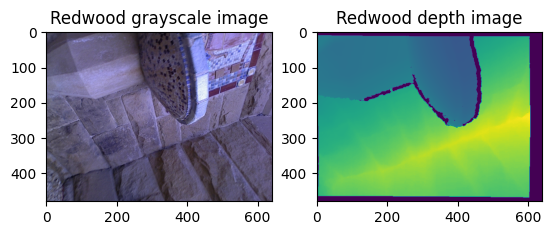

In [5]:
# def sorted_file(file_list):
#     convert = lambda text: int(text) if text.isdigit() else text
#     alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
#     return sorted(file_list, key=alphanum_key)

sorted_file = lambda file_list: sorted(file_list, key=lambda x: int(''.join(filter(str.isdigit, x))))


rgbd_images = []
DataFolder = "RGBD_Data\SampleFountainRGBDImages"
fountain_rgbd_dataset_color_paths = sorted_file([DataFolder+"\\image\\"+os.path.relpath(i) for i in os.listdir(DataFolder+"\\image")])
fountain_rgbd_dataset_depth_paths = sorted_file([DataFolder+"\\depth\\"+os.path.relpath(i) for i in os.listdir(DataFolder+"\\depth")])
for i in range(len(fountain_rgbd_dataset_depth_paths)):
    depth = o3d.io.read_image(fountain_rgbd_dataset_depth_paths[i])
    color = o3d.io.read_image(fountain_rgbd_dataset_color_paths[i])
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color, depth, convert_rgb_to_intensity=False)
    # print(rgbd_image)
    rgbd_images.append(rgbd_image)
# 读取摄像机轨迹和mesh
camera_trajectory = o3d.io.read_pinhole_camera_trajectory(
    DataFolder+"\\scene\\key.log")
mesh = o3d.io.read_triangle_mesh(
    DataFolder+"\\scene\\integrated.ply")

# Load dataset
# print(mesh, rgbd_images, camera_trajectory)
print(rgbd_image)
plt.subplot(1, 2, 1)
plt.title('Redwood grayscale image')
plt.imshow(rgbd_image.color)
plt.subplot(1, 2, 2)
plt.title('Redwood depth image')
plt.imshow(rgbd_image.depth)
plt.show()

In [ ]:
mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh],
                                  mesh_show_back_face=True,
                                  zoom=0.5399,
                                  front=[0.0665, -0.1107, -0.9916],
                                  lookat=[0.7353, 0.6537, 1.0521],
                                  up=[0.0136, -0.9936, 0.1118])

## 对比，无优化
为了直观地看到摄像机的位姿如何不利于颜色贴图，这段代码故意将迭代数设为0，这意味着没有优化。color_map_optimization使用相应的RGBD图像和摄像机位姿来绘制网格。没有优化，纹理图就会模糊不清。

In [ ]:
# Before full optimization, let's visualize texture map
# with given geometry, RGBD images, and camera poses.
mesh, camera_trajectory = o3d.pipelines.color_map.run_rigid_optimizer(
    mesh, rgbd_images, camera_trajectory,
    o3d.pipelines.color_map.RigidOptimizerOption(maximum_iteration=0))
o3d.visualization.draw_geometries([mesh],
                                #   mesh_show_back_face=True,
                                  zoom=0.5399,
                                  front=[0.0665, -0.1107, -0.9916],
                                  lookat=[0.7353, 0.6537, 1.0521],
                                  up=[0.0136, -0.9936, 0.1118])

## 刚性优化
下一步是优化摄像机的位姿，以获得一个清晰的颜色图。

下面的代码为实际迭代设置了maximum_iteration = 300。

残留误差意味着图像强度的不一致。较低的残差会导致更好的颜色地图质量。

默认情况下，ColorMapOptimizationOption启用刚性优化。它对每个摄像机的6维位姿进行优化。

In [ ]:
# Optimize texture and save the mesh as texture_mapped.ply
# This is implementation of following paper
# Q.-Y. Zhou and V. Koltun,
# Color Map Optimization for 3D Reconstruction with Consumer Depth Cameras,
# SIGGRAPH 2014

# Run rigid optimization.
is_ci = True
maximum_iteration = 100 if is_ci else 300
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    mesh, camera_trajectory = o3d.pipelines.color_map.run_rigid_optimizer(
        mesh, rgbd_images, camera_trajectory,
        o3d.pipelines.color_map.RigidOptimizerOption(
            maximum_iteration=maximum_iteration))

o3d.visualization.draw_geometries([mesh],
                                  zoom=0.5399,
                                  front=[0.0665, -0.1107, -0.9916],
                                  lookat=[0.7353, 0.6537, 1.0521],
                                  up=[0.0136, -0.9936, 0.1118])


## 非刚性优化

In [ ]:
# Run non-rigid optimization.
is_ci = True
maximum_iteration = 100 if is_ci else 300
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    mesh, camera_trajectory = o3d.pipelines.color_map.run_non_rigid_optimizer(
        mesh, rgbd_images, camera_trajectory,
        o3d.pipelines.color_map.NonRigidOptimizerOption(
            maximum_iteration=maximum_iteration))


In [ ]:
o3d.visualization.draw_geometries([mesh],
                                  zoom=0.5399,
                                  front=[0.0665, -0.1107, -0.9916],
                                  lookat=[0.7353, 0.6537, 1.0521],
                                  up=[0.0136, -0.9936, 0.1118])